In [1]:
import pandas as pd
import numpy as np
import os
import pathlib
from collections import defaultdict
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
codes_dir = pathlib.Path('./code')
embedding_dir = pathlib.Path('./embeddings')

In [3]:
antipatterns = list(embedding_dir.glob('*'))
antipatterns_dict = {}
for antipattern in antipatterns:
    antipatterns_dict[antipattern.name] = list(antipattern.glob('*'))

In [4]:
# TODO, what can be tried: LSTM where sequence is number of methods, 1D convolutions, Bert

In [5]:
labels = defaultdict(lambda : [False, False, False, False, ''])
name2label = {name:i for name, i in zip(antipatterns_dict, range(len(antipatterns_dict)))}
label2name = {value:key for key, value in name2label.items()}
for name, paths in antipatterns_dict.items():
    for path in paths:
        labels[os.path.basename(path)][name2label[name]] = True
        labels[os.path.basename(path)][-1] = path

In [6]:
def get_embedding(filename):
    return np.array([float(x) for x in filename.open().read().split()])

for name, values in labels.items():
    labels[name].append(get_embedding(values[-1]).reshape(384, -1))

In [7]:
name2label

{'data_class': 0,
 'god_classes': 1,
 'feature_envy': 2,
 'parallel_inheritance_hierarchies': 3}

In [8]:
def get_train_labels(name):
    return [np.mean(values[-1], axis=1) for values in labels.values()], [values[name2label[name]] for values in labels.values()]

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

def fit(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    svm = SVC()
    svm.fit(X_train, y_train)
    preds = svm.predict(X_test)
    print(classification_report(y_test, preds))

## Data Class

In [10]:
X, y = get_train_labels('data_class')
fit(X, y)

              precision    recall  f1-score   support

       False       0.87      0.74      0.80       158
        True       0.62      0.80      0.70        84

    accuracy                           0.76       242
   macro avg       0.75      0.77      0.75       242
weighted avg       0.79      0.76      0.77       242



## God Classes

In [11]:
X, y = get_train_labels('god_classes')
fit(X, y)

              precision    recall  f1-score   support

       False       0.89      0.87      0.88       166
        True       0.73      0.76      0.75        76

    accuracy                           0.84       242
   macro avg       0.81      0.82      0.81       242
weighted avg       0.84      0.84      0.84       242



## Feature envy

In [12]:
X, y = get_train_labels('feature_envy')
fit(X, y)

              precision    recall  f1-score   support

       False       1.00      0.19      0.32        31
        True       0.89      1.00      0.94       211

    accuracy                           0.90       242
   macro avg       0.95      0.60      0.63       242
weighted avg       0.91      0.90      0.86       242



## Parallel inheritance

In [13]:
X, y = get_train_labels('parallel_inheritance_hierarchies')
fit(X, y)

              precision    recall  f1-score   support

       False       0.82      1.00      0.90       192
        True       1.00      0.16      0.28        50

    accuracy                           0.83       242
   macro avg       0.91      0.58      0.59       242
weighted avg       0.86      0.83      0.77       242



## Skmultilearn

In [14]:
X, y = np.array([np.mean(values[-1], axis=1) for values in labels.values()]), np.array([values[:4] for values in labels.values()])

In [15]:
# Import BinaryRelevance from skmultilearn
from skmultilearn.problem_transform import BinaryRelevance

# Import SVC classifier from sklearn
from sklearn.svm import SVC

# Setup the classifier
classifier = BinaryRelevance(classifier=SVC(), require_dense=[False,True])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Train
classifier.fit(X_train, y_train)

# Predict
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.80      0.70        84
           1       0.73      0.76      0.75        76
           2       0.89      1.00      0.94       211
           3       1.00      0.16      0.28        50

   micro avg       0.80      0.82      0.81       421
   macro avg       0.81      0.68      0.67       421
weighted avg       0.82      0.82      0.78       421
 samples avg       0.86      0.86      0.82       421



## Experiments

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
from skmultilearn.problem_transform import ClassifierChain, LabelPowerset
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

from sklearn.svm import SVC

parameters = {
    'classifier': [BinaryRelevance(), ClassifierChain()],
    'classifier__classifier': [RandomForestClassifier()],
    'classifier__classifier__n_estimators': [10, 20, 50],
    
    'clusterer' : [
        NetworkXLabelGraphClusterer(LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False), 'louvain'),
        NetworkXLabelGraphClusterer(LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False), 'lpa')
    ]
}

clf = GridSearchCV(LabelSpacePartitioningClassifier(), parameters, scoring = 'f1_macro')
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

{'classifier': BinaryRelevance(classifier=RandomForestClassifier(n_estimators=50),
                require_dense=[True, True]), 'classifier__classifier': RandomForestClassifier(n_estimators=50), 'classifier__classifier__n_estimators': 50, 'clusterer': <skmultilearn.cluster.networkx.NetworkXLabelGraphClusterer object at 0x7efd7ae599b0>} 0.6255634693149451


In [18]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.51      0.59        84
           1       0.88      0.50      0.64        76
           2       0.90      0.98      0.94       211
           3       0.79      0.22      0.34        50

   micro avg       0.86      0.71      0.78       421
   macro avg       0.82      0.55      0.63       421
weighted avg       0.85      0.71      0.75       421
 samples avg       0.89      0.77      0.79       421



/home/vlad/anaconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters = {'k': range(1,6), 's': [0.0, 0.5, 0.7, 1.0]}
score = 'f1_micro'

clf = GridSearchCV(MLkNN(), parameters, scoring=score)
clf.fit(X_train, y_train)

print (clf.best_params_, clf.best_score_)

{'k': 5, 's': 0.0} 0.6833407544443361


In [20]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.43      0.75      0.55        84
           1       0.37      0.99      0.53        76
           2       0.89      1.00      0.94       211
           3       0.34      0.22      0.27        50

   micro avg       0.58      0.86      0.69       421
   macro avg       0.51      0.74      0.57       421
weighted avg       0.64      0.86      0.71       421
 samples avg       0.61      0.88      0.67       421



In [21]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
edge_map = graph_builder.transform(y_train)
print("{} labels, {} edges".format(4, len(edge_map)))
print(edge_map)

4 labels, 6 edges
{(0, 1): 201.0, (0, 2): 308.0, (1, 2): 204.0, (0, 3): 53.0, (2, 3): 125.0, (1, 3): 37.0}


In [22]:
{(label2name[key[0]],label2name[key[1]]):value for key, value in edge_map.items()}

{('data_class', 'god_classes'): 201.0,
 ('data_class', 'feature_envy'): 308.0,
 ('god_classes', 'feature_envy'): 204.0,
 ('data_class', 'parallel_inheritance_hierarchies'): 53.0,
 ('feature_envy', 'parallel_inheritance_hierarchies'): 125.0,
 ('god_classes', 'parallel_inheritance_hierarchies'): 37.0}

In [23]:
import networkx as nx
# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')
partition = clusterer.fit_predict(X_train,y_train)

membership_vector = to_membership_vector(partition)

names_dict = dict(enumerate(x for x in ['data', 'god', 'envy', 'inheritance']))

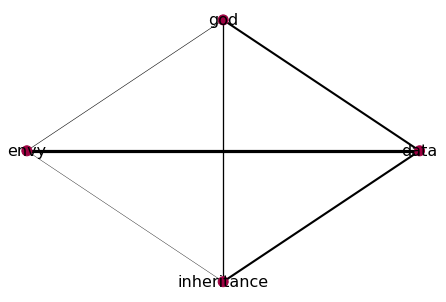

In [24]:
nx.draw(
    clusterer.graph_,
    pos=nx.circular_layout(clusterer.graph_),
    labels=names_dict,
    with_labels = True,
    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=100,
    font_size=16
)

Reference: [Scikit Multilearn doc](http://scikit.ml/index.html)